# Basic GIS Tools with Rasterio

Albin Wells -- Last updated October 2022

This notebook provides a framework and sample of ways to execute some basic GIS geoprocessing steps in python using the rasterio module. This notebook goes through examples on how to:
- plot shapefiles and geotiff files
- convert netCDF data to geotiff
- clip geotiff files with a shapefile or another geotiff
- reproject shapefiles
- resample and reproject geotiff files
- fill holes in geotiff data
- mosaic two geotiffs

### Import necessary modules

In [1]:
# rasterio, xarray, rioxarray, matplotlib, matplotlib_scalebar, numpy, fiona, geopandas, pandas
import rasterio
import rasterio.plot
from rasterio.plot import show
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from rasterio.windows import from_bounds
from rasterio.fill import fillnodata

import rioxarray
import xarray

import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import cm
import fiona
import shapely.geometry
import geopandas as gpd
import pandas as pd

In [ ]:
# from raster_basics.RasterBasics import FUNCTION
# from raster_basics.DataPlots import FUNCTION
# from raster_basics.GlacierFunctions import FUNCTION
# from raster_basics.BaseFunctions import FUNCTION

### Identify data files and plot data

- Glacier outline inventory was downloaded from the [GLIMS Glacier Database](https://www.glims.org/RGI/rgi60_dl.html)
- The RGI Region 1 ice thickness data from Millan et al. 2022 was accessed from [this online portal](https://doi.org/10.6096/1007)
- The netCDF thickness for Gulkana was taken from Farinotti et al. 2019, accessed from [this portal](https://doi.org/10.3929/ethz-b-000315707), and converted into a netCDF file separately for experimental purposes
- The elevation change rate data to show mosaicking was published in Hugonnet et al. 2021 and acessed from [this portal](https://doi.org/10.6096/13)


In [2]:
regional_thickness = 'Millan_Thickness_RGI1.tif' # rgi region 1 ice thickness data (Millan et al. 2022)
rgi_glaciers = '01_rgi60_Alaska.shp' # region 1 randolph glacier inventory dataset (RGI Consortium)

# let's use regional thickness and regional shapefile

In [3]:
rgi_glaciers = '/Users/albinwells/Desktop/GlacierMB/Other/01_rgi60_Alaska-2.shp'

We can make plots pretty easily with matplotlib. 
In this case, I've added a [scalebar](https://pypi.org/project/matplotlib-scalebar/) which is based on the image extent (this is only the case when dx is set to 1).
We can also give it any color scheme which is based on [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

In [4]:
def show_fig(image, title, color, ctitle, bounds=None, res=None, vmin=None, vmax=None, savefig=False):
    fig, ax = plt.subplots(figsize=(12,6))
    c = ax.imshow(image, cmap=color, extent=bounds, vmin=vmin, vmax=vmax)
    if res != None:
        ax.add_artist(ScaleBar(dx=res, units='m')) # add scalebar
    fig.colorbar(c, label=ctitle)
    fig.suptitle(title)
    plt.show()
    if savefig == True:
        fig.savefig(title + '.jpg', dpi=1000) # to save the plot as a jpg image


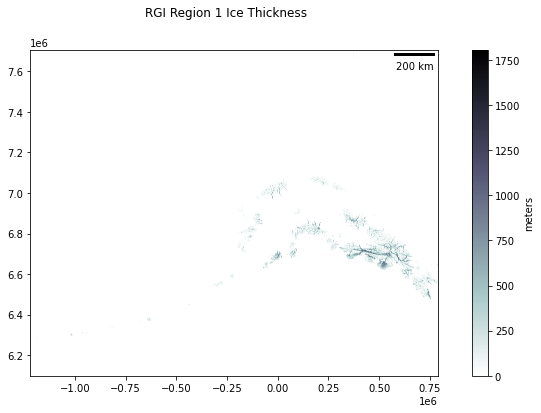

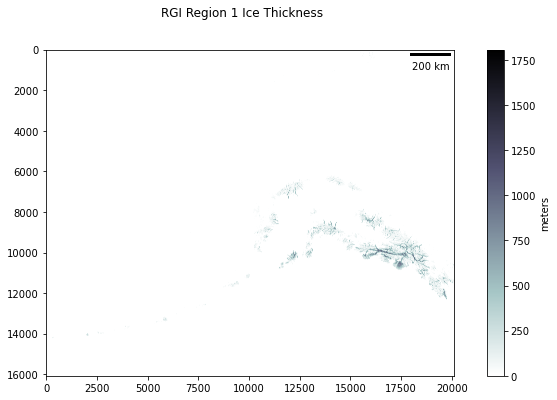

In [5]:
im = rasterio.open(regional_thickness).read(1)
rast_bounds = rasterio.open(regional_thickness).bounds # left, bottom, right, top
fig_bounds = [rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]] # left, right, bottom, top
title = 'RGI Region 1 Ice Thickness'
color = 'bone_r'
ctitle = 'meters'
show_fig(im, title, color, ctitle, bounds=fig_bounds, res=1)

# identical to the last figure, but we have axis as array coordinates not map coordinates. Scalebar still works
show_fig(im, title, color, ctitle, res=rasterio.open(regional_thickness).res[0])

Now, we can also very quickly look at a geoTIFF by calling the built-in rasterio.plot show function:

<AxesSubplot:title={'center':'RGI Region 1 Ice Thickness'}>

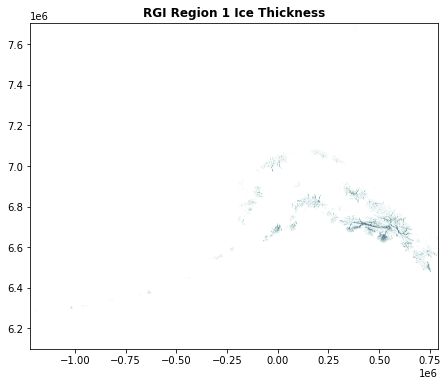

In [6]:
rast = rasterio.open(regional_thickness)

fig, ax = plt.subplots(figsize=(12,6))
show((rast, 1), ax=ax, cmap=color, title=title)

If we have input data as a netCDF file instead of a geotiff, one solution is to convert it to a geotiff and then follow the same steps. Note that we need to extract the desired variable (in this instance "uvelsurf", "vvelsurf", and "velsurf_mag")

<xarray.Dataset>
Dimensions:      (time: 2, y: 266, x: 356)
Coordinates:
  * time         (time) float32 0.0 1.0
  * y            (y) float32 9.175e+06 9.175e+06 ... 9.162e+06 9.162e+06
  * x            (x) float32 -1.62e+07 -1.62e+07 ... -1.618e+07 -1.618e+07
Data variables:
    topg         (time, y, x) float32 ...
    usurf        (time, y, x) float32 ...
    thk          (time, y, x) float32 ...
    smb          (time, y, x) float32 ...
    velbar_mag   (time, y, x) float32 ...
    velsurf_mag  (time, y, x) float32 ...
    uvelbase     (time, y, x) float32 ...
    vvelbase     (time, y, x) float32 ...
    uvelsurf     (time, y, x) float32 ...
    vvelsurf     (time, y, x) float32 ...
    divflux      (time, y, x) float32 ...


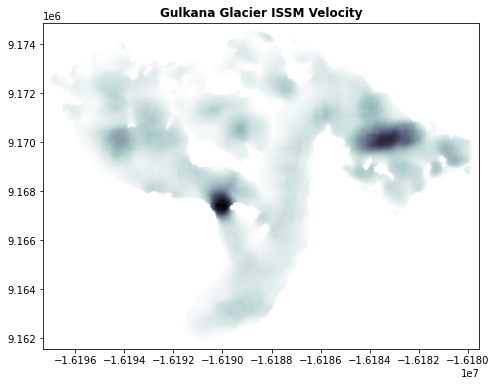

In [8]:
netcdf_file = 'ISSM_millan_model_output.nc'
xds = xarray.open_dataset(netcdf_file, decode_coords='all')
print(xds)
xds['velsurf_mag'].rio.to_raster('test_v.tif')

fig, ax = plt.subplots(figsize=(12,6))
show((rasterio.open('test_v.tif'), 1), ax=ax, cmap=color, title='Gulkana Glacier ISSM Velocity')

os.remove('test_v.tif')

### Extract our glacier outline

First, we have the RGI region 1 dataset. Here are some [mapping tips](https://geopandas.org/en/stable/docs/user_guide/mapping.html)

            RGIId         GLIMSId   BgnDate   EndDate   CenLon  CenLat  \
0  RGI60-01.00001  G213177E63689N  20090703  -9999999 -146.823  63.689   
1  RGI60-01.00002  G213332E63404N  20090703  -9999999 -146.668  63.404   
2  RGI60-01.00003  G213920E63376N  20090703  -9999999 -146.080  63.376   
3  RGI60-01.00004  G213880E63381N  20090703  -9999999 -146.120  63.381   
4  RGI60-01.00005  G212943E63551N  20090703  -9999999 -147.057  63.551   

  O1Region O2Region   Area  Zmin  ... Status Connect  Form TermType Surging  \
0        1        2  0.360  1936  ...      0       0     0        0       9   
1        1        2  0.558  1713  ...      0       0     0        0       9   
2        1        2  1.685  1609  ...      0       0     0        0       9   
3        1        2  3.681  1273  ...      0       0     0        0       9   
4        1        2  2.573  1494  ...      0       0     0        0       9   

  Linkages  Name            layer  \
0        9  None  01_rgi60_Alaska   
1     

<AxesSubplot:>

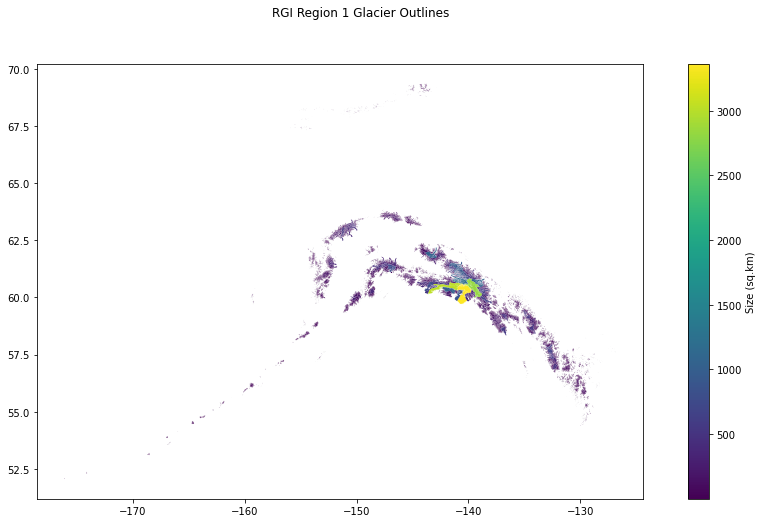

In [7]:
glaciers = gpd.read_file(rgi_glaciers)
print(glaciers.head()) # to show the first 5 rows of the shapefile data
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('RGI Region 1 Glacier Outlines')
glaciers.plot(column='Area', ax=ax, legend=True, legend_kwds={'label': 'Size (sq.km)', 'orientation': 'vertical'})


The "big pancake" [Malaspina glacier](https://en.wikipedia.org/wiki/Malaspina_Glacier) really sticks out even in a map of the entire region!
This is what it looks like from up-close (ish):

![Malaspina](https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Malaspina_Glacier%2C_Alaska_%2822800052331%29.jpg/1280px-Malaspina_Glacier%2C_Alaska_%2822800052331%29.jpg)

Now, let's focus on Gulkana and extract the shapefile feature:

<AxesSubplot:>

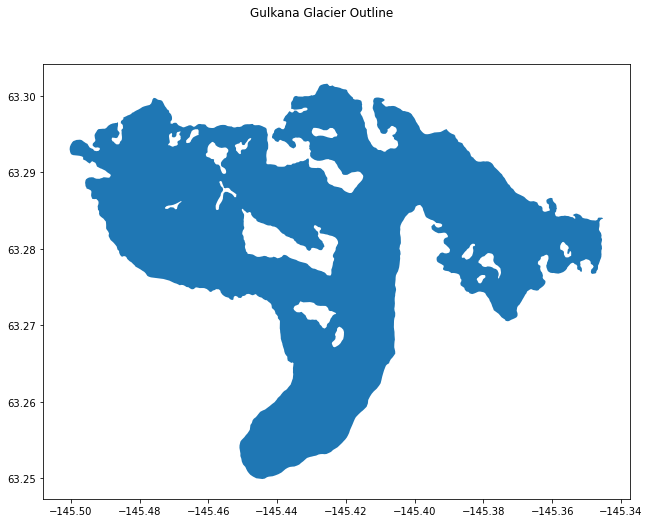

In [8]:
gulkana = glaciers[glaciers['Name']=='Gulkana Glacier']
# print(gulkana)
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Outline')
gulkana.plot(ax=ax)

Let's save this as our new outline

In [9]:
gulkana_file = 'gulkana.shp'
gulkana.to_file(gulkana_file)

### Reproject files into the same coordinate system

**First, let's define a target coordinate system that we want to work in and a target resolution**

In [10]:
crs = 'EPSG:32606'  # UTM zone 6N
res = 20 # output pixel resolution (m)

**Now, let's reproject the shapefile**

In [11]:
def shpReprojection(shapefile, crs, dst='reprojected_shape.shp'):
    src = gpd.read_file(shapefile)
    src = src.to_crs(crs)
    src.to_file(dst)

In [12]:
reprojected_shp = 'gulkana_utm.shp'
shpReprojection(gulkana_file, crs, reprojected_shp)

We can plot and see that we're not seeing UTM Easting/Northing coordinates instead of the WGS84 Lat/Lon coordinates

<AxesSubplot:>

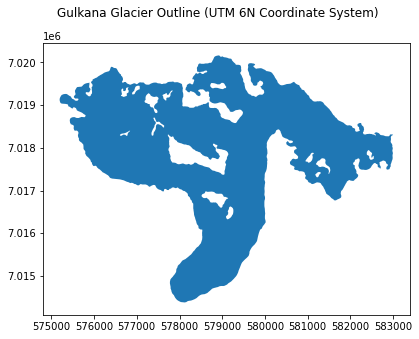

In [13]:
gulkana_utm = gpd.read_file(reprojected_shp)
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Gulkana Glacier Outline (UTM 6N Coordinate System)')
gulkana_utm.plot(ax=ax)

### Before we resample and reproject, let's clip the extent so we don't waste time doing this for the entire region 

We can use the Gulkana shapefile to clip the regional geotiff. We can also clip a geotiff based on the extent of another geotiff, but in this case there's no need

We use the [rasterio.mask module](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html). A few of the parameters I've included are:
- **Crop *(boolean)*:** Whether to crop the raster to the extent of the shapes. Default is False
- **Filled *(boolean)*:** If True, the pixels outside the features will be set to nodata. If False, the output array will contain the original pixel data, and only the mask will be based on shapes. Default is True
- **Nodata *(int or float)*:** Value representing nodata within each raster band. Default is 0
- **Pad *(boolean)*:** If True, the features will be padded in each direction by one half of a pixel prior to cropping raster. Default is False
- **Pad_width *(int or float)*:** Width of padding in pixels, if Pad is True. Default is 0.5

In [15]:
def shpClip(geotiff, shapefile, destination, nan_val=0, fill=True, pad_size=0):
    # clip a geotiff with a shapefile
    with rasterio.open(geotiff) as src:
        # we need to make a temporary shapefile with the same crs as the geotiff 
        shpReprojection(shapefile, src.crs, dst='temp.shp')
        with fiona.open('temp.shp', 'r') as shapefile:
            shapes = [feature['geometry'] for feature in shapefile]

        out_image, out_transform = rasterio.mask.mask(
            src, 
            shapes, 
            crop=True, 
            filled=fill, 
            nodata=nan_val, 
            pad=True, 
            pad_width=pad_size
        )
        
        out_image[np.isnan(out_image)] = 0
        kwargs = src.meta
        kwargs.update({'driver': 'GTiff',
                       'height': out_image.shape[1],
                       'width': out_image.shape[2],
                       'transform': out_transform})
        with rasterio.open(destination, 'w', **kwargs) as dst:
            dst.write(out_image)
            
    for f in glob.glob('temp.*'): # remove the 'temp.*' shapefiles
        os.remove(f)

In [16]:
gulkana_clipped = 'gulkana_thickness.tif' # output filename
shpClip(regional_thickness, reprojected_shp, gulkana_clipped, pad_size=10)
print('Initial coordinate system:', rasterio.open(gulkana_clipped).crs)
print('Initial resolution:', rasterio.open(gulkana_clipped).res, 'meters')

Initial coordinate system: EPSG:32607
Initial resolution: (100.0, 100.0) meters


Let's plot to see out result:

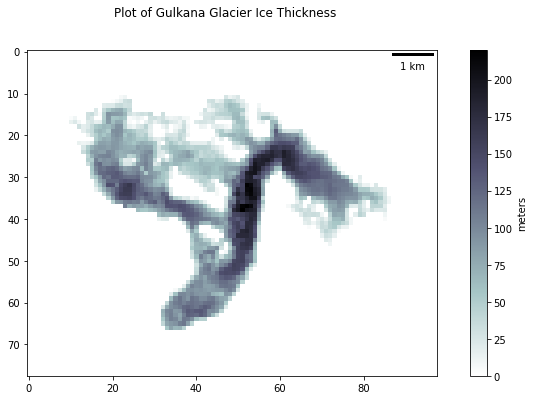

In [17]:
im = rasterio.open(gulkana_clipped)
title = 'Plot of Gulkana Glacier Ice Thickness'
color = 'bone_r'
ctitle = 'meters'
show_fig(im.read(1), title, color, ctitle, res=im.res[0])

If we wanted to clip a geotiff using another geotiff, we use the [rasterio.windows from_bounds function](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html#rasterio.windows.from_bounds) as follows:

In [26]:
# def tifClip(geotiff, geotiff_clip):
#     # clip a geotiff to the bounds of another geotiff_clip
#     # NOTE: watch out when using this function, it may shift some data. 
#     # I would recommend reprojecting the data to 'clip' it
#     # This is done by defining the 'width', 'height', and 'bounds' from another array in calculate_default_transform
#     with rasterio.open(geotiff) as src:
#         dst = rasterio.open(geotiff_clip)
#         dstBounds = dst.bounds  # bounds of destination tif (left, bottom, right, top)
#         kwargs = src.meta.copy()
#         kwargs.update({
#             'height': dst.height,
#             'width': dst.width,
#             'transform': dst.transform
#         })

#         destination = 'clipped_output.tif'
#         with rasterio.open(destination, 'w', **kwargs) as dst:
#             w = from_bounds(dstBounds[0], dstBounds[1], dstBounds[2], dstBounds[3], src.transform)
#             dst.write(src.read(window=w))

**Then, let's reproject the geotiff raster file**

For this, we first use the [calculate_default_transform function from the rasterio.warp module](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.calculate_default_transform).

Then, we use the [reproject function from the rasterio.warp module](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject). Note that there are a lot of [different resampling algorithms](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling), in this can I chose a cubic spline as it was consistent with some [literature](https://www.nature.com/articles/s41467-021-23073-4).

In [18]:
def tifReprojectionResample(file, reprojected_tif, crs, res, interp, extent_file=None):
    # open and obtain file transformation information, then perform reprojection
    with rasterio.open(file) as src:
        if extent_file is None:
            # keep initial file bounds
            transform, width, height = calculate_default_transform(
                src.crs,
                crs,
                src.width,
                src.height,
                *src.bounds,
                resolution=res
            )
        else:
            # this readjusts the bounds to be that of extent_file
            dst = rasterio.open(extent_file)
            transform, width, height = calculate_default_transform(
                src.crs,
                crs,
                dst.width,
                dst.height,
                *dst.bounds,
                resolution=res
            )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(reprojected_tif, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=interp   # Resampling.cubic_spline
            )

In [19]:
gulkana_reprojected = 'gulkana_thickness_utm.tif' # output filename
tifReprojectionResample(gulkana_clipped, gulkana_reprojected, crs, res, Resampling.cubic_spline)
print('New coordinate system:', rasterio.open(gulkana_reprojected).crs)
print('New resolution:', rasterio.open(gulkana_reprojected).res, 'meters')

New coordinate system: EPSG:32606
New resolution: (20.0, 20.0) meters


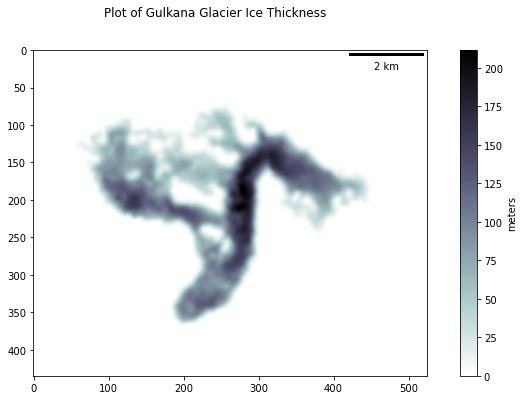

In [20]:
im = rasterio.open(gulkana_reprojected)
title = 'Plot of Gulkana Glacier Ice Thickness'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

### Filling Missing Data

This is an example of how to quickly fill a hole in data. First, let's simulate data gaps. Then, we'll see how to fix it

In [21]:
with rasterio.open(gulkana_reprojected) as src:
    image = src.read(1)
    image[150] = np.nan
    image[200,280] = np.nan
    kwargs = src.meta.copy()
    destination = 'gulkana_with_datagaps.tif'
    with rasterio.open(destination, 'w', **kwargs) as dst:
        dst.write_band(1, image)

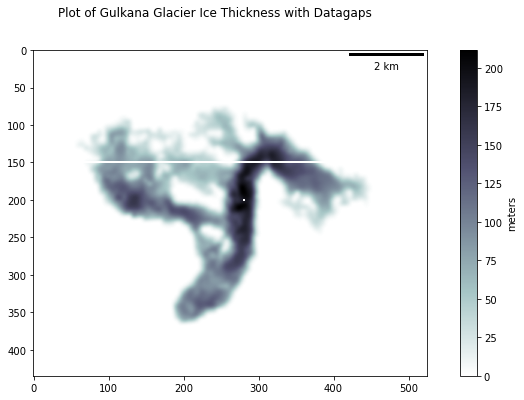

In [22]:
im = rasterio.open('gulkana_with_datagaps.tif')
title = 'Plot of Gulkana Glacier Ice Thickness with Datagaps'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

If we have a gap in our data, we can fill it using functions from the [rasterio.fill module](https://rasterio.readthedocs.io/en/latest/api/rasterio.fill.html#rasterio.fill.fillnodata)

In [23]:
def fillHole(file, dest='filled.tif', dist=10, iters=1):
    with rasterio.open(file) as src:
        profile = src.profile
        inputs = src.read(1)
        
        fillmask = inputs.copy() # fillnodata is applied where the mask=0
        fillmask[inputs>=0] = 1
        fillmask[fillmask!=1] = 0
        
        inputFilled = fillnodata(inputs, mask=fillmask, max_search_distance=dist, smoothing_iterations=iters)
        inputFilled[pd.isnull(inputFilled) == True] = 0
        
    with rasterio.open(dest, 'w', **profile) as dst:
        dst.write_band(1, inputFilled)

Let's see if this worked and filled the data with a reasonable value!

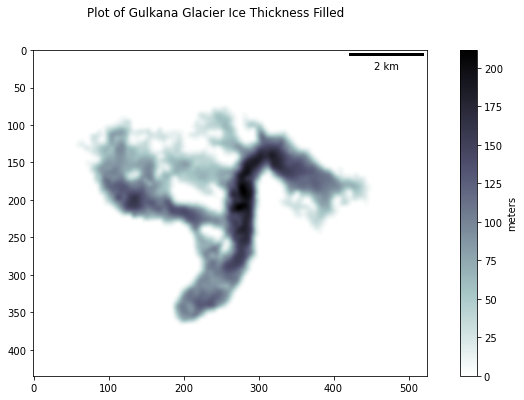

In [24]:
fillHole('gulkana_with_datagaps.tif', dest='gulkana_filled.tif')

im = rasterio.open('gulkana_filled.tif')
title = 'Plot of Gulkana Glacier Ice Thickness Filled'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

Filling worked pretty effectively, but it isn't identical to the original:

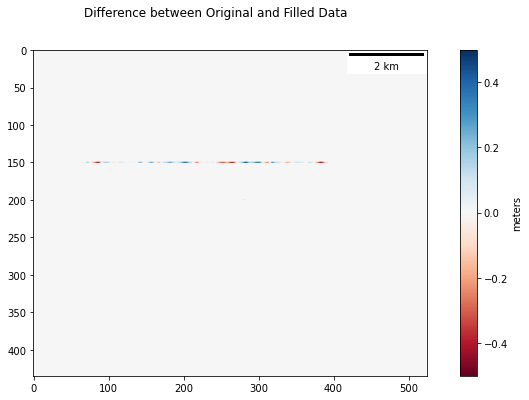

In [25]:
original = rasterio.open(gulkana_reprojected)
filled = rasterio.open('gulkana_filled.tif')
difference = np.subtract(original.read(1), filled.read(1))
title = 'Difference between Original and Filled Data'
show_fig(difference, title, color='RdBu', ctitle='meters', res=filled.res[0], vmin=-0.5, vmax=0.5)

### Mosaicking

Sometimes, data might be split into multiple gridded sections. We can mosaic these grids into a larger area if we want to do some analysis that spans grid cells. We use 4 1x1 degree grid cells from Hugonnet et al. 2021 for elevation change rate in Alaska.

In [6]:
tile1 = 'N60W140_2000-2020_dhdt.tif'
tile2 = 'N60W141_2000-2020_dhdt.tif'
tile3 = 'N59W140_2000-2020_dhdt.tif'
tile4 = 'N59W141_2000-2020_dhdt.tif'
dhdt_files = [tile1, tile2, tile3, tile4]

In [7]:
im = rasterio.open(tile1)
im.crs

CRS.from_epsg(32607)

Check that coordinate systems are consistent

In [27]:
for file in dhdt_files:
    print(file, 'has coordinate system:', rasterio.open(file).crs)

N60W140_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N60W141_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N59W140_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N59W141_2000-2020_dhdt.tif has coordinate system: EPSG:32607


Mosaicking relies on the [rasterio.merge module](https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html#rasterio.merge.merge):

In [28]:
def mosaic_files(files, mosaic_output):
    # create a mosiac of the obtained raster files. reproject files to the same crs if needed
    src_files_to_mosaic = []
    dst_crs = rasterio.open(files[0]).crs
    for file in files:
        src = rasterio.open(file)   
        if src.crs != dst_crs: # NOTE: files must have the same crs
            raise 'Both datasets do not share a common coordinate system. One must be reprojected.'
        src_files_to_mosaic.append(src)
        
    mosaic, out_trans = merge(src_files_to_mosaic)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                             'height': mosaic.shape[1],
                             'width': mosaic.shape[2],
                             'transform': out_trans})
    with rasterio.open(mosaic_output, 'w', **out_meta) as dest:
        dest.write(mosaic)


In [29]:
mosaic_output = 'dhdt_mosaic.tif'
mosaic_files(dhdt_files, mosaic_output)

**Finally, let's plot the result**

Let's obtain the proper shapefile shape and reproject it into the coordinate system...

In [30]:
malaspina = glaciers[glaciers['Name']=='Seward Glacier']
# print(malaspina)
malaspina_file = 'malaspina.shp'
malaspina.to_file(malaspina_file)
shpReprojection(malaspina_file, rasterio.open(tile1).crs, 'malaspina_utm.shp')

...and then plot it on top of our mosaic!

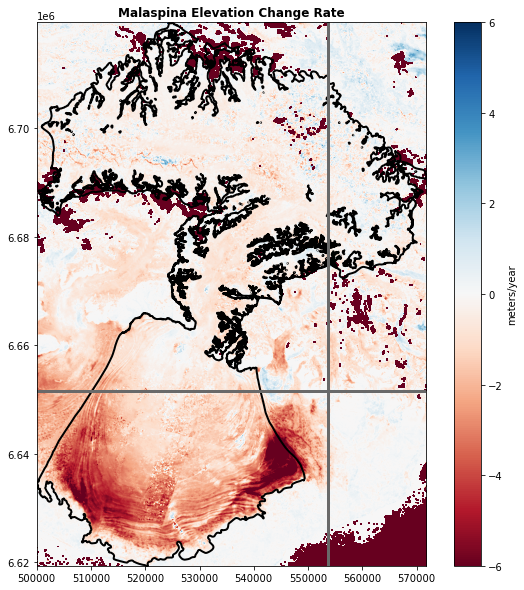

In [31]:
mosaic_array = rasterio.open(mosaic_output).read(1)

fig, ax = plt.subplots(figsize=(10,10))
c = ax.imshow(mosaic_array, cmap='RdBu', vmin=-6, vmax=6) # plot mosaic
show((rasterio.open(mosaic_output), 1), ax=ax, cmap='RdBu', 
     title='Malaspina Elevation Change Rate', vmin=-6, vmax=6)
fig.colorbar(c, label='meters/year', ax=ax)

malaspina_utm = gpd.read_file('malaspina_utm.shp') # plot shapefile
malaspina_utm.plot(ax=ax, facecolor='#FF000000', edgecolor='k', lw=2)

bounds = fiona.open('malaspina_utm.shp').bounds # crop plot my shapefile bounds
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.axvline(x = rasterio.open(tile1).bounds[0], color = 'dimgray', lw=3) # show where our initial grids were
plt.axhline(y = rasterio.open(tile1).bounds[1], color = 'dimgray', lw=3)
plt.show()


## Miscellaneous

### Function to get a raster from an array.
Useful for saving an array obtained from a raster after doing some computation on it

In [34]:
def rasterLike(array, destination, geotiff):
    # Create a raster (with name destination) from an array, with the same metadata as an existing geotiff
    with rasterio.open(geotiff) as src:
        kwargs = src.meta.copy()
    with rasterio.open(destination, 'w', **kwargs) as dst:
        dst.write(array, 1)

### How to sample a raster along a line and make a graph

In [32]:
tiff_name = 'dhdt_mosaic.tif'
main_title = 'Malaspina dhdt'
cbar_title = 'Change in Elevation (m/yr)'
color = 'RdBu'
v_min = -6
v_max = 6

Build a simple GUI to determine where we want to sample our data

In [33]:
def sample_on_line(geotiff, vmin, vmax, cmap, c_label, title):
    # a gui to create a transect
    global stored_xvals, stored_yvals, asci, asci_list
    %matplotlib tk
    asci = 64
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(16, 10)

    # print and store selected values
    stored_xvals = []
    stored_yvals = []
    asci_list = []
    def onclick(event): # mouse click event
        global stored_xvals, stored_yvals, asci, asci_list
        asci = asci+1
        asci_list.append(asci)
        ix, iy = event.xdata, event.ydata
        stored_xvals.append(ix)
        stored_yvals.append(iy) 

        plt.autoscale(False)
        plt.plot(stored_xvals, stored_yvals, color='r', zorder=10) 
        plt.plot(ix, iy, color='r', marker='.', markersize=8, zorder=10)
        ax.annotate(chr(asci), (ix+10, iy+10), color='r', fontsize=16, zorder=20)
        plt.show()
        plt.savefig('Sampling along a line.jpg', dpi=300)

    cid = fig.canvas.mpl_connect('button_press_event', onclick) # initiate the butten click event

    tiff = rasterio.open(geotiff)
    rast_bounds = tiff.bounds # left, bottom, right, top
    c = ax.imshow(tiff.read(1), cmap=cmap, vmin=vmin, vmax=vmax) # plot mosaic
    plt.imshow(tiff.read(1), cmap=cmap, vmin=vmin, vmax=vmax, 
               extent=[rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]])
    fig.colorbar(c, label=c_label, ax=ax)

    plt.xlabel('UTM Easting (m)', fontsize=12)
    plt.ylabel('UTM Northing (m)', fontsize=12)
    plt.title(title, fontsize=24, c='k')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [34]:
# obtain the sampling transect using the GUI
sample_on_line(geotiff=tiff_name, vmin=v_min, vmax=v_max, cmap=color, c_label=cbar_title, title=main_title)


Now, let's sample along the line we just drew and plot the result

In [35]:
def extract_along_line(xarr, line, n_samples=512):
    # samples line with n_samples number of points
    profile = []
    dist = []
    for i in range(n_samples):
        point = line.interpolate(i / n_samples - 1., normalized=True) # get next point on the line
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data # access the nearest pixel in the xarray
        profile.append(value)
        dist.append([point.x, point.y])
    return profile, dist

def end_points(xarr, points):
    # obtains raster values at our point selections themselves (not interpolated lines)
    point_spot = []
    for p in points:
        point = xarr.sel(x=p[0], y=p[1], method="nearest").data # access the nearest pixel in the xarray
        point_spot.append(point)
    return point_spot

In [36]:
# extract raster values along the line
line_points = list(zip(stored_xvals, stored_yvals))
line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
xarr = rioxarray.open_rasterio(tiff_name).squeeze()
profile, coordinate = extract_along_line(xarr, line)
points = end_points(xarr, line_points)


In [37]:
# get the raster values along the line and the distances along the transect
vals = [float(x) for x in profile]
line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
dist = [sum(dist[:i]) for i in range(len(dist)+1)]

p_vals = [float(x) for x in points]
line_point_dists = [[line_points[i], line_points[i+1]] for i in range(len(line_points)-1)]
p_dist = [math.dist(pair[0], pair[1]) for pair in line_point_dists]
p_dist = [sum(p_dist[:i]) for i in range(len(p_dist)+1)]

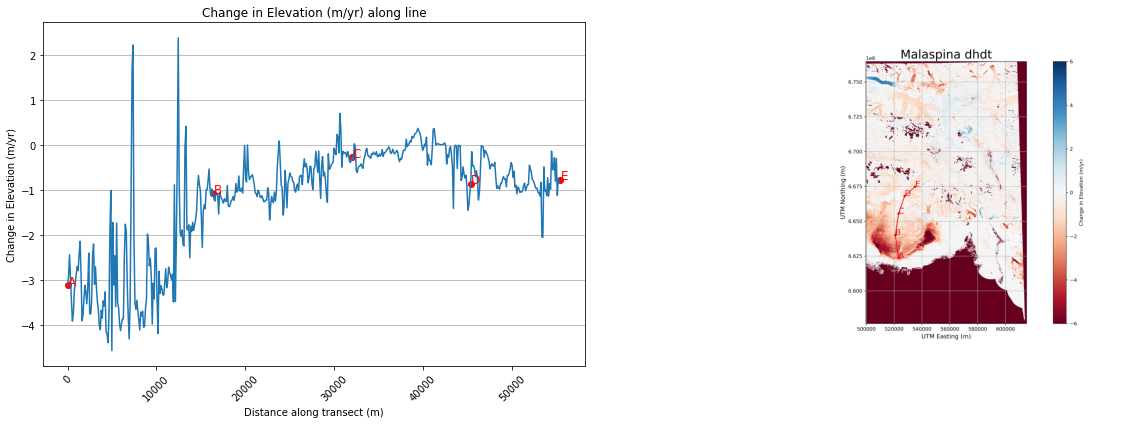

In [38]:
# plot the results
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(dist, vals)
ax1.scatter(p_dist, p_vals, color='r')
for i in range(len(asci_list)):
    ax1.annotate(chr(asci_list[i]), (p_dist[i]+20, p_vals[i]), color='r', fontsize=12)
ax1.grid(axis='y')
ax1.set_xlabel('Distance along transect (m)')
ax1.set_ylabel(cbar_title)
ax1.set_title(cbar_title + ' along line', c='k')
plt.setp(ax1.get_xticklabels(), rotation=45);

pic = plt.imread('Sampling along a line.jpg')
ax2.imshow(pic)
ax2.axis('off')
plt.tight_layout()


### How to get raster values along OGGM flowline

In this case, let's plot thickness along a flowline

In [39]:
tiff_name = 'gulkana_thickness_utm.tif'
# shapefile_name = 'gulkana-flowline.shp'
shapefile_name = 'RGI01_flowlines/RGI01_flowlines_utm.shp'
main_title = 'Gulkana Thickness'
cbar_title = 'Thickness (m)'
color = 'bone_r'
v_min = 0
v_max = 250

Let's look at our flowline for Gulkana

<AxesSubplot:>

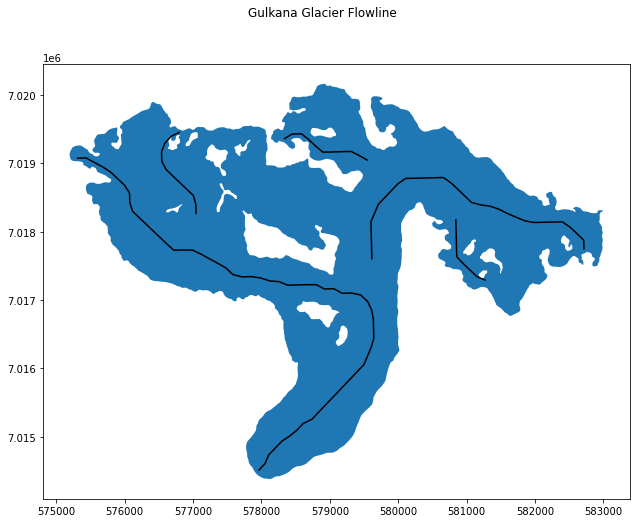

In [40]:
flowline = gpd.read_file(shapefile_name)
flowline = flowline[flowline['RGIID']=='RGI60-01.00570'] # get Gulkana flowline if we use regional OGGM flowlines
# print(glaciers.head()) # to show the first 5 rows of the shapefile data
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Flowline')

gulkana_utm.plot(ax=ax)
flowline.plot(ax=ax, color='k')
# show((rasterio.open(tiff_name), 1), ax=ax, cmap='Blues')


...and only use the flowline for the main trunk, to keep things simpler

<AxesSubplot:>

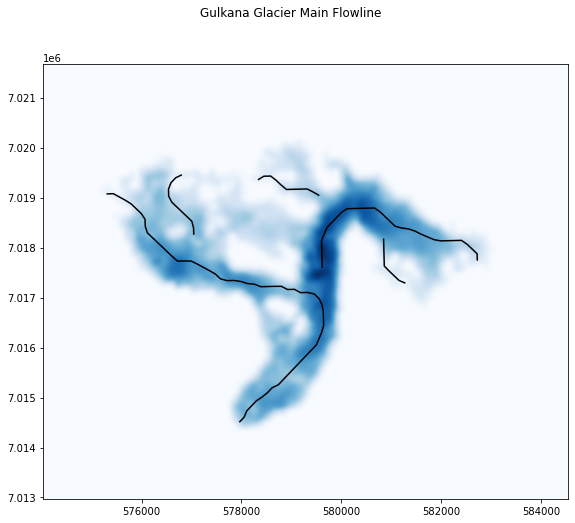

In [41]:
# main_flowline = flowline[flowline['name']=='flowline_main'] # if we're using my created flowline
main_flowline = flowline[flowline['SEGMENT_ID'] >= 0] # if we're using OGGM flowline
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Main Flowline')
# gulkana_utm.plot(ax=ax)
main_flowline.plot(ax=ax, color='k')
show((rasterio.open(tiff_name), 1), ax=ax, cmap='Blues')


Now, let's sample along the line and plot the result

In [42]:
# extract raster values along the line
xarr = rioxarray.open_rasterio(tiff_name).squeeze()
profile, coordinate = [], []
ids = main_flowline['SEGMENT_ID']
for g in main_flowline['geometry']:
    prof, coord = extract_along_line(xarr, g)
    profile.append(prof)
    coordinate.append(coord)


In [43]:
# get the raster values along the line and the distances along the transect
vals, line_dists, dist = [], [], []

for n in range(len(profile)):
    v = [float(x) for x in profile[n]]
    line_d = [[coordinate[n][i], coordinate[n][i+1]] for i in range(len(coordinate[n])-1)]
    d = [math.dist(pair[0], pair[1]) for pair in line_d]
    d = [sum(d[:i]) for i in range(len(d)+1)]
    vals.append(v)
    line_dists.append(line_d)
    dist.append(d)


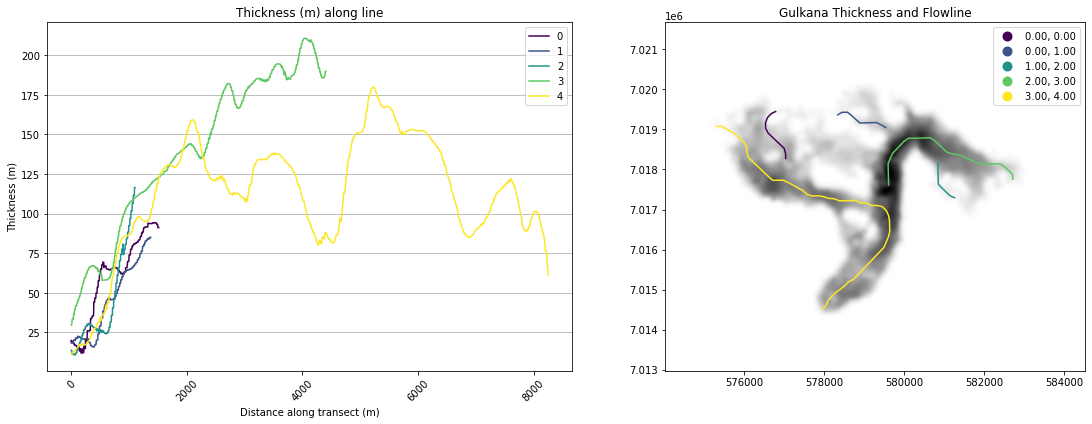

In [44]:
# plot the results
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm_subsection = np.linspace(0, 1, len(dist)) 
colors = [cm.viridis(x) for x in cm_subsection]
for i, c in enumerate(colors):
    ax1.plot(dist[i], vals[i], color=c)
ax1.grid(axis='y')
ax1.set_xlabel('Distance along transect (m)')
ax1.set_ylabel(cbar_title)
ax1.set_title(cbar_title + ' along line', c='k')
ax1.legend(ids)
plt.setp(ax1.get_xticklabels(), rotation=45);

main_flowline.plot(ax=ax2, column='SEGMENT_ID', cmap='viridis', legend=True, scheme='natural_breaks')
show((rasterio.open(tiff_name), 1), ax=ax2, cmap='Greys')
ax2.set_title('Gulkana Thickness and Flowline', c='k')
plt.tight_layout()

In [ ]:
# Google EarthEngine / EarthExplorer module/environment in Python?
